# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В моем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится.

Необходимо построить модель с максимально большим значением *accuracy*. Нужно довести долю правильных ответов по крайней мере до 0.75 и проверить *accuracy* на тестовой выборке.

# Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
 - сalls — количество звонков,
 - minutes — суммарная длительность звонков в минутах,
 - messages — количество sms-сообщений,
 - mb_used — израсходованный интернет-трафик в Мб,
 - is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Открытие и изучение файла с данными

Импортирую библиотеки и открываю файл с данными

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

Изучаю общую информацию о таблице

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.tail()

,calls,minutes,messages,mb_used,is_ultra
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0
3213,80.0,566.09,6.0,29480.52,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [6]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [7]:
df.duplicated().sum()

0

Глядя на данные файла, можно сказать, что файл прошел предобработку, отсутствуют пропущенные значения, в строковых значениях однородный регистр. Явные дубликаты в строках отсутствуют. Изменю только тип данных в колонке со звонками и сообщениями на целочисленный тип, так как количество звонков и количество сообщений не отображаются в дробном виде. 

In [8]:
df['calls'] = df['calls'].astype('int')

In [9]:
df['messages'] = df['messages'].astype('int')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


**Вывод:**

1. Таблица импортирована
2. Типы данных приведены в соответствие
3. В наименовании столбцов используется однородный регистр
4. Отсутствуют явные дубликаты

## Разделение данных на выборки

Перед тем как разбить данные на выборки, объявлю две переменные, в которых разделю таблицу на признаки и целевой признак. В соответствии с поставленной задачей, целевым признаком является колонка `is_ultra`.

In [11]:
#переменная содержащая признаки
features = df.drop('is_ultra', axis=1)
#переменная содержащая целевой признак
target = df['is_ultra']

Теперь, после разделения таблицы на признаки, необходимо разобить данные на выборки. Так как тестовой выборки у нас нет, разобью данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1. Для разбивки на выборки использую функцию `train_test_split` библиотеки `sklearn`.

In [12]:
#разбиваю данные на тренировочную и валидационную выборки
features_train, features_valid, target_train, target_valid = train_test_split(
                                                            features, target, test_size=0.4,
                                                            random_state=12345)
#разбиваю валидационную выборку на валидационную и тестовую выборки
features_test, features_valid, target_test, target_valid = train_test_split(
                                                            features_valid, target_valid, 
                                                            test_size=0.5, random_state=12345)

In [13]:
display(features_train.shape)
display(target_train.shape)
display(features_valid.shape)
display(target_valid.shape)
display(features_test.shape)
display(target_test.shape)

(1928, 4)

(1928,)

(643, 4)

(643,)

(643, 4)

(643,)

**Вывод:**

- данные таблицы разделены на признаки и целевой признак
- целевым признаком является колонка `is_ultra`
- данные разбиты на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 (60%, 20%, 20%).

## Обучение моделей

### Решающее дерево

Проверю качество обученной модели на основе валидационной выборки. Инициирую модель `DecisionTreeClassifier` из библиотеки `sklearn`.
Вычисление точности проведу с помощью метода `accuracy_score`.

Accuracy наилучшей модели на валидационной выборке: 0.7993779160186625 Глубина дерева: 7


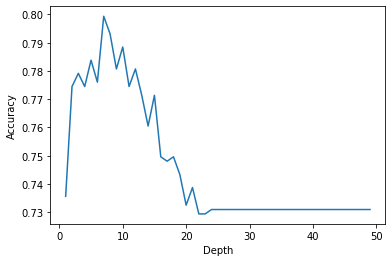

In [15]:
best_model_dtc = None
best_result_dtc = 0
best_depth_dtc = 0
depth_valid = []
result_valid = []
for depth in range(1, 50):
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth) # обучаю модель с заданной глубиной дерева
    model_dtc.fit(features_train, target_train) # обучаю модель на тренировочной выборке
    predictions_valid_dtc = model_dtc.predict(features_valid) # получаю предсказания модели на валидационной выборке
    result_dtc = accuracy_score(target_valid, predictions_valid_dtc) # считаю качество модели на валидационной выборке
    depth_valid.append(depth)
    result_valid.append(result_dtc)
    if result_dtc > best_result_dtc:
        best_model_dtc = model_dtc # сохраняю наилучшую модель
        best_result_dtc = result_dtc #  сохраняю наилучшее значение метрики accuracy на валидационных данных
        best_depth_dtc = depth # сохраняю наилучшую глубину дерева
print('Accuracy наилучшей модели на валидационной выборке:', best_result_dtc, 'Глубина дерева:', best_depth_dtc)

plt.plot(depth_valid, result_valid)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

Наилучшая точность модели решающего дерева на валидационной выборке соответствует **79,9%** при глубине дерева **7**.

### Случайный лес

Теперь найду наилучшую точность обученной модели на основе валидационной выборки с помощью модели `RandomForestClassifier` из библиотеки `sklearn`.
Вычисление точности также проведу с помощью метода `accuracy_score`.

Accuracy наилучшей модели на валидационной выборке: 0.8133748055987559 Количество деревьев: 10 Максимальная глубина: 19


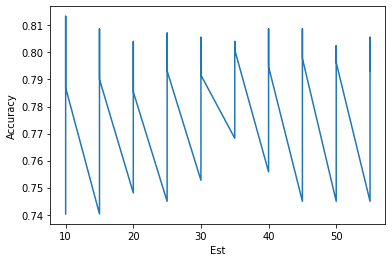

In [16]:
best_model_rfc = None
best_result_rfc = 0
best_est_rfc = 0
best_depth_rfc = 0
est_valid = []
result_valid = []
for est in range(10, 60, 5):
    for depth in range (1, 20):
        # инициализирую модель RandomForestRegressor с параметрами random_state=12345, n_estimators=est и max_depth=depth
        model_rfc = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        # обучаю модель на тренировочной выборке
        model_rfc.fit(features_train, target_train)
        # получаю предсказания модели на валидационной выборке
        predictions_valid_rfc = model_rfc.predict(features_valid)
        # считаю качество модели
        result_rfc = accuracy_score(target_valid, predictions_valid_rfc)
        est_valid.append(est)
        result_valid.append(result_rfc)
        if result_rfc > best_result_rfc:
            best_model_rfc = model_rfc
            best_result_rfc = result_rfc
            best_est_rfc = est
            best_depth_rfc = depth

print('Accuracy наилучшей модели на валидационной выборке:', best_result_rfc, 'Количество деревьев:', best_est_rfc, 'Максимальная глубина:', depth)

plt.plot(est_valid, result_valid)
plt.xlabel('Est')
plt.ylabel('Accuracy')
plt.show()

Наилучшее качество модели случайного леса соответствует **81%** при количестве деревьев **10** и глубине деревьев **19**, что почти на 2% выше, чем у модели решающего дерева.

### Логистическая регрессия

Далее необходимо рассмотреть, как обучается модель при логистической регресии. Применю модель `LogisticRegression` из библиотеки `sklearn` и вычислю `accuracy`.

In [17]:
model_lr = LogisticRegression(random_state=12345, max_iter=10000)
model_lr.fit(features_train, target_train)
predictions_valid_lr = model_lr.predict(features_valid)
result_lr = accuracy_score(target_valid, predictions_valid_lr)

              
print('Accuracy модели на валидационной выборке:', result_lr)

Accuracy модели на валидационной выборке: 0.6842923794712286


У логистической регрессии оказалась самая наименьшая точность модели **68%**.

**Вывод:**

- Наилучшая точность модели решающего дерева составляет 79,9%
- Наилучшая точность модели случайного леса составляет 81%
- Точность модели логистической регрессии составляет 68%

## Проверка лучшей модели на тестовой выборке

По результатам проверки на валидационной выборке, лучшей моделью является модель случайного леса с точностью 81%, количеством деревьев 10 и максимальной глубиной 19.

Проверю данную модель на тестовой выборке, чтобы убедиться в работоспособности модели.

In [18]:
predictions_test_rfc = best_model_rfc.predict(features_test)
result_rfc_test = accuracy_score(target_test, predictions_test_rfc)
print('Accuracy модели на тестовой выборке:', result_rfc_test)

Accuracy модели на тестовой выборке: 0.7853810264385692


Точность модели на тестовой выборке случайного леса составляет 78,5%, точность не много ниже, чем при проверке на валидационной выборке, но все же соответствует требованию с точностью правильных ответов (accuracy) не менее 75%. 

## Проверка модели на адекватность

Чтобы оценить адекватность модели или проверить ее на вменяемость, необходимо сравнивайте модель со случайной. Проведу проверку модели на адекватность с помощью классификатора `DummyClassifier` из библиотеки `sklearn`. Применю параметр `uniform`, который генерирует прогнозы равномерно случайным образом и каждый класс имеет равную вероятность.

In [19]:
dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(features_train, target_train)
dummy_clf.predict(features_valid)
dummy_clf.score(features_train, target_train)

0.4979253112033195

Качество случайной модели составляет всего 49%, качество моделей при проверке на валидационной и тестовой выборках значительно выше, что говорит об адекватности и вменяемости моделей.

## Общий вывод

В ходе выполнения проекта, было выполнено следущее:

- разбиты данные на выборки:обучающую, валидационную и тестовую в соотношении 3:1:1;
- выделены признаки и целевой признак;
- созданы и обучены модели для задач классификации: решающее дерево, случайный лес и логистическая регрессия;
- рассчитана точность моделей для валидационной выборки, наилучшая точность соответствует модели случайного леса;
- проверена точность моделей на тестовой выборке, наилучшей точностью, также соответствует модель случайного леса;
- проверена модель на адекватность и вменяемость.